In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
filepath = 'bank-full.csv'

# Wrangle Function 

In [3]:
def wrangle(filepath):
    #loading data from the csv file
    df = pd.read_csv(filepath, delimiter=";")
    
    #removing the duration column. Because, according to the data dictionary,
    #the output feature "y" depends highly on the duration feature.
    #And it should be used only for benchmark purpose
    df.drop(columns="duration", inplace=True)
    
    return df

In [4]:
df = wrangle(filepath)

# Exploration

In [5]:
print(df.shape)
df.head()

(45211, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  poutcome   45211 non-null  object
 15  y          45211 non-null  object
dtypes: int64(6), object(10)
memory usage: 5.5+ MB


In [7]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

There is no missing value in the data.

In [8]:
df["balance"].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

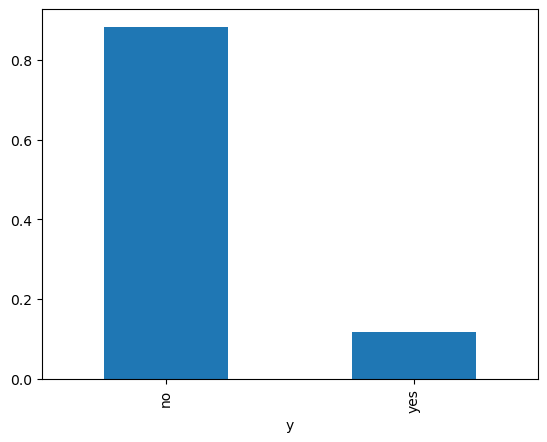

In [9]:
df["y"].value_counts(normalize=True).plot(kind="bar");

In [10]:
majority, minority = df["y"].value_counts(normalize=True)
majority, minority

(0.8830151954170445, 0.11698480458295547)

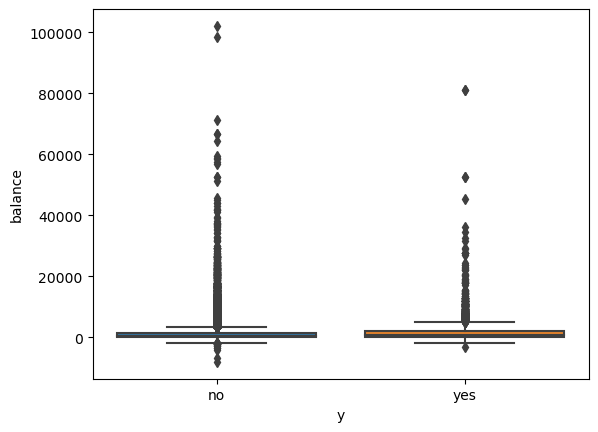

In [11]:
sns.boxplot(data=df, x="y", y="balance");

In [12]:
df["balance"].describe().apply("{0:,.0f}".format)

count     45,211
mean       1,362
std        3,045
min       -8,019
25%           72
50%          448
75%        1,428
max      102,127
Name: balance, dtype: object

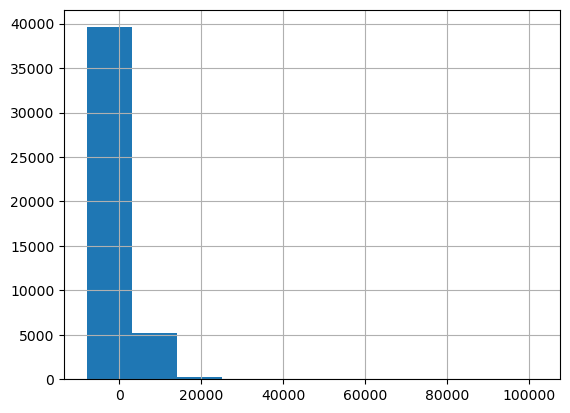

In [13]:
df["balance"].hist();

In [14]:
p, q = df["balance"].quantile([0.1, 0.9])
mask = df["balance"].between(p,q)

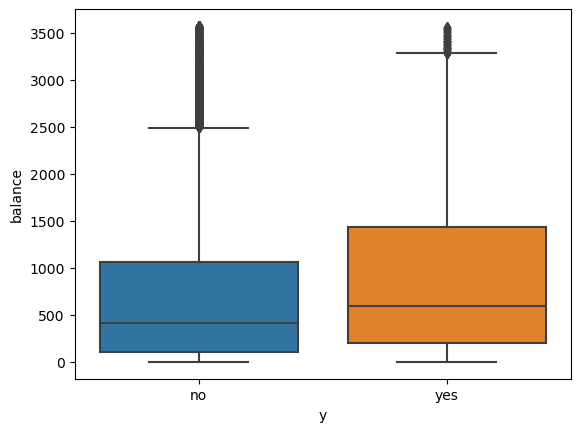

In [15]:
sns.boxplot(data=df[mask], x="y", y="balance");

In [16]:
df.select_dtypes("object").nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
y             2
dtype: int64

# Split

In [17]:
target = "y"
X = df.drop(columns="y")
y = df[target]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [19]:
over_sample = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sample.fit_resample(X_train, y_train)

# Build Model

# Baseline

In [20]:
baseline = df["y"].value_counts(normalize=True)[0]
print("Baseline Accuracy:", round(baseline,4))

Baseline Accuracy: 0.883


# Iteration

In [21]:
clf = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    RandomForestClassifier(random_state=42)
)

In [22]:
CV_score = cross_val_score(clf, X_train_over, y_train_over, n_jobs=-1)

In [23]:
print(CV_score)

[0.97403816 0.97411636 0.97192681 0.97646231 0.97442915]


In [24]:
params = {
    "randomforestclassifier__n_estimators": range(25,100,25),
    "randomforestclassifier__max_depth": range(10,50,10)
}
params

{'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

In [25]:
model = GridSearchCV(clf, params, cv=5, n_jobs=-1, verbose=1)
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(use_cat_names=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25)},
             verbose=1)

In [26]:
model.best_estimator_

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['job', 'marital', 'education', 'default',
                                     'housing', 'loan', 'contact', 'month',
                                     'poutcome'],
                               use_cat_names=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=40, n_estimators=50,
                                        random_state=42))])

In [27]:
model.predict(X_train_over)

array(['no', 'no', 'no', ..., 'yes', 'yes', 'yes'], dtype=object)

# Evaluation

In [28]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train,4))
print("Test Accuracy:", round(acc_test,4))

Training Accuracy: 1.0
Test Accuracy: 0.8839


In [29]:
y_test.value_counts()

y
no     7952
yes    1091
Name: count, dtype: int64

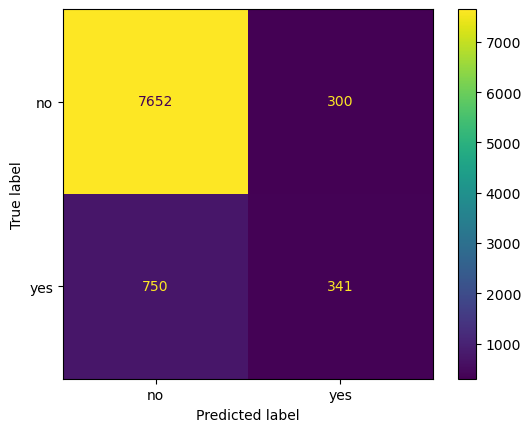

In [30]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

# Communication

Text(0.5, 1.0, 'Feature Importance')

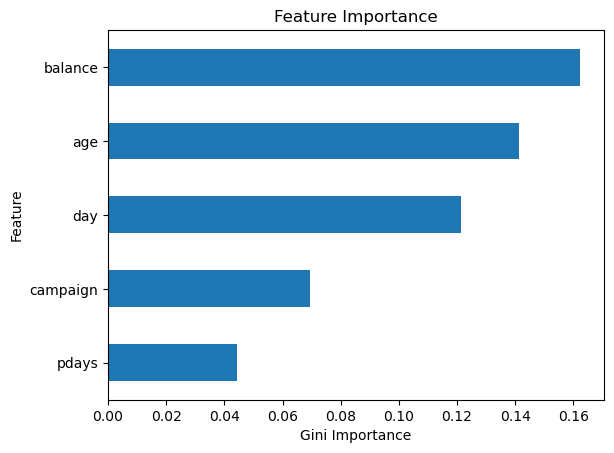

In [31]:
# Get feature names from training data
features = model.best_estimator_.named_steps["onehotencoder"].get_feature_names_out(X.columns)

# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_

# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
# Plot 10 most important features
feat_imp.tail().plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")